<a href="https://colab.research.google.com/github/neilsoneja/canecheck/blob/main/VGG16_PD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import random
import cv2
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.utils import to_categorical
from skimage.transform import rotate

from google.colab import drive

drive.mount('/content/drive')

def get_files(path):
    files = list()

    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            files.append(os.path.join(dirname, filename))

    return files

train_files_path = get_files('/content/drive/MyDrive/Colab Notebooks/PD/dataset')

train_csv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PD/dataset.csv')

print("Train files : {0}".format(len(train_files_path)))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train files : 484


In [ ]:
train_dict = dict(zip(train_csv.image, train_csv.target))
print(train_dict['102.jpg'])

Variety 1


In [ ]:
random.shuffle(train_files_path)
split = int(len(train_files_path) * 0.8)
train_files = train_files_path[:split]
val_files = train_files_path[split:]

print("Training files {0}".format(len(train_files)))
print("Validation files {0}".format(len(val_files)))

Training files 387
Validation files 97


In [ ]:
unique_labels = list(set(train_dict.values()))
unique_labels_mapping = dict()
for index in range(len(unique_labels)):
    unique_labels_mapping[unique_labels[index]] = index

total_classes = len(unique_labels)
print("Number of classes : {0}".format(total_classes))

Number of classes : 5


In [ ]:
def get_one_hot_encoded_mask(value, num_labels):
    return to_categorical(value, num_classes = num_labels)

In [ ]:
img_width, img_height = 100, 100
batch_size = 50
epochs = 20
learning_rate = 1e-4

In [ ]:
def rotate_image(image, angle_list):
    rotated_images = list()
    for angle in angle_list:
        rotated_images.append(rotate(image,angle))

    return rotated_images

In [ ]:
def scaleDown_image(image, fx=0.6, fy=0.6):
    return cv2.resize(image, None, fx= 0.6, fy= 0.6, interpolation= cv2.INTER_LINEAR)

In [ ]:
def scaleUp_image(image, fx = 2, fy = 2):
    return cv2.resize(image, None, fx = fx, fy = fy, interpolation= cv2.INTER_LINEAR)

In [ ]:
def horizontal_flip(img):
    return img[: , ::-1]

In [ ]:
def blur(img, kernel=(5,5)):
    return cv2.GaussianBlur(img, kernel, 0)

In [ ]:
def brightness(img, low=-50, high=50):
    brightness = np.random.randint(low, high)
    img = img + brightness
    return img

In [ ]:
class DataGenerator:
    def __init__(self, train_files, valid_files, labels_dict, batch_size = 32, val_augment = True):
        self.train_files = train_files
        self.valid_files = valid_files
        self.labels_dict = labels_dict
        self.batch_size = batch_size
        self.val_augment = val_augment

    def train_generator(self):
        num_images = len(self.train_files)
        while True:
            x_batch = list()
            y_batch = list()
            index_list = list(range(0,num_images))
            index_list = shuffle(index_list)
            for idxs in range(0, num_images, self.batch_size):
                x_batch = list()
                y_batch = list()
                for idx in index_list[idxs:min(idxs+self.batch_size, num_images)]:

                    img = cv2.imread(self.train_files[idx])
                    img = cv2.resize(img, (img_width, img_height))
                    img = img / 255
                    x_batch.append(img)

                    image_name = self.train_files[idx].split("/")
                    label = unique_labels_mapping[train_dict[str(image_name[-1])]]
                    label = get_one_hot_encoded_mask(label, total_classes)
                    y_batch.append(label)

                    rotated_images = rotate_image(img, [45, 60, -45, -60])
                    for rotated_image in rotated_images:
                        x_batch.append(rotated_image)
                        y_batch.append(label)

                    x_batch.append(horizontal_flip(img))
                    y_batch.append(label)

                    x_batch.append(blur(img))
                    y_batch.append(label)

                    x_batch.append(brightness(img))
                    y_batch.append(label)

                x_batch, y_batch = shuffle(x_batch, y_batch, random_state=0)
                yield (np.asarray(x_batch), np.asarray(y_batch))

    def valid_generator(self):
        num_images = len(self.valid_files)
        while True:
            x_batch = list()
            y_batch = list()
            index_list = list(range(0,num_images))
            index_list = shuffle(index_list)
            for idxs in range(0, num_images, self.batch_size):
                x_batch = list()
                y_batch = list()
                for idx in index_list[idxs:min(idxs+self.batch_size, num_images)]:

                    img = cv2.imread(self.valid_files[idx])
                    img = cv2.resize(img, (img_width, img_height))
                    img  = img / 255
                    x_batch.append(img)

                    image_name = self.valid_files[idx].split("/")
                    label = unique_labels_mapping[train_dict[str(image_name[-1])]]
                    label = get_one_hot_encoded_mask(label, total_classes)
                    y_batch.append(label)

                    if self.val_augment:
                        rotated_images = rotate_image(img, [45, 60, -45, -60])
                        for rotated_image in rotated_images:
                            x_batch.append(rotated_image)
                            y_batch.append(label)

                        x_batch.append(horizontal_flip(img))
                        y_batch.append(label)

                        x_batch.append(blur(img))
                        y_batch.append(label)

                        x_batch.append(brightness(img))
                        y_batch.append(label)

                x_batch, y_batch = shuffle(x_batch, y_batch, random_state=0)
                yield (np.asarray(x_batch), np.asarray(y_batch))

In [ ]:
epoch_steps = int(math.ceil(len(train_files) / batch_size) * 8)
print(epoch_steps)
val_steps = int(math.ceil(len(val_files) / batch_size) * 8)
print(val_steps)

64
16


In [ ]:
from keras.applications import inception_v3, inception_resnet_v2, VGG16
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from keras.models import Model
import tensorflow.keras as keras

In [ ]:
base_model = VGG16(include_top=False, input_shape=(img_width, img_height, 3),
                    weights='imagenet')
x = base_model.output
x = Flatten()(x)
x = Dense(72,activation='relu')(x)
x = Dropout(0.5)(x)
final_layer = Dense(total_classes,activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=final_layer)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 100, 100, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 50, 50, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 25, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 72)                  │         331,848 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,046,901 (57.40 MB)

 Trainable params: 15,046,901 (57.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer=SGD(learning_rate=learning_rate , momentum = 0.9),
              loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
datagen = DataGenerator(train_files, val_files, train_dict, batch_size)

In [ ]:
history = model.fit(
    x=datagen.train_generator(),  # Use the generator function for training data
    steps_per_epoch=epoch_steps,  # Number of steps per epoch
    epochs=20,                   # Number of epochs
    validation_steps=val_steps,  # Number of validation steps
    validation_data=datagen.valid_generator(),  # Use the generator function for validation data
    verbose=1                    # Verbosity mode
)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 243s 4s/step - accuracy: 0.2448 - loss: 1.7445 - val_accuracy: 0.5380 - val_loss: 1.3021
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 192s 3s/step - accuracy: 0.5010 - loss: 1.2411 - val_accuracy: 0.7297 - val_loss: 0.7805
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.6714 - loss: 0.8237 - val_accuracy: 0.7790 - val_loss: 0.5473
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.7671 - loss: 0.5901 - val_accuracy: 0.8101 - val_loss: 0.4567
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.8307 - loss: 0.4465 - val_accuracy: 0.8305 - val_loss: 0.4155
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.8558 - loss: 0.3841 - val_accuracy: 0.8634 - val_loss: 0.3328
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.8809 - loss: 0.3253 - val_accuracy: 0.8702 - val_loss: 0.3193
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.8892 - loss: 0.3005 - val_accuracy: 0.9006 - v

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


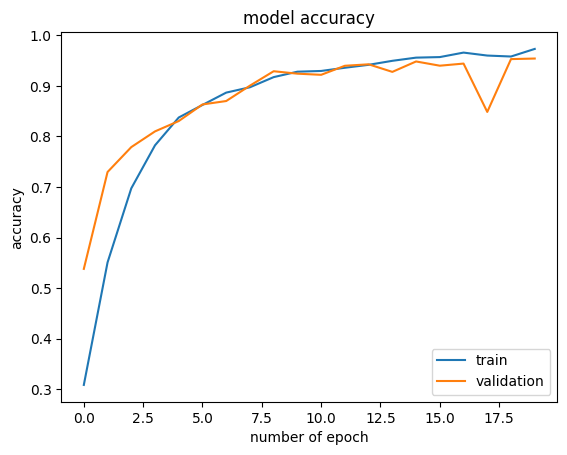

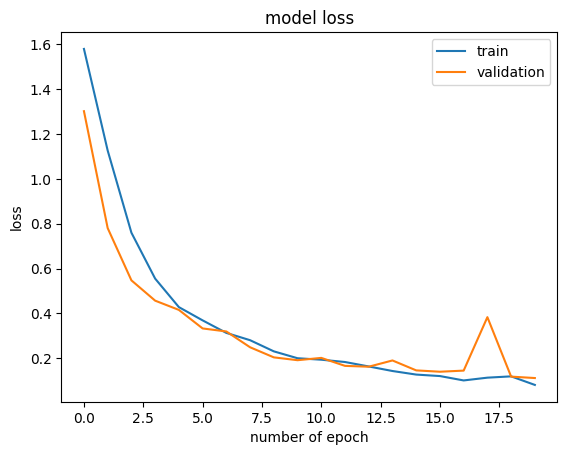

In [ ]:
print(history.history.keys())
# "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('number of epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('number of epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


In [ ]:
from google.colab import files
from tensorflow.keras.models import save_model

#model_save_path = '/content/drive/MyDrive/Colab Notebooks/PD/Final_VGG16_ver1'
#model.save(model_save_path)

model.save('final_vgg16_ver1.h5')  # Save the model to a file
files.download('final_vgg16_ver1.h5')  # Download the saved model file

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
inv_map = {v: k for k, v in unique_labels_mapping.items()}
print(inv_map)

{0: 'Variety 4', 1: 'Variety 3', 2: 'Variety 5', 3: 'Variety 2', 4: 'Variety 1'}


In [ ]:
test_csv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PD/testing.csv')

test_images = test_csv['image']
print(test_images[:5])

0    144.jpg
1    386.jpg
2    499.jpg
3    382.jpg
4    582.jpg
Name: image, dtype: object


In [ ]:
output = list()
for index in range(len(test_images)):
    img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/PD/testing/' + str(test_images[index]))
    img = cv2.resize(img, (img_width, img_height))
    img = img / 255
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    output.append(inv_map[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━

In [ ]:
df = pd.DataFrame({'Image': test_images,
                   'target': output})
df.to_csv("/content/drive/MyDrive/Colab Notebooks/PD/output.csv", index=False)